In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import os
from glob2 import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_dir = 'dataset/nomal_data/train'
test_dir = 'dataset/nomal_data/test'
val_dir = 'dataset/nomal_data/val'
an_dir = 'data1/anomal_data/'
image_size = (100, 100)
batch_size = 64

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_gen = datagen.flow_from_directory(train_dir,
                                        target_size=image_size,
                                        batch_size=batch_size,
                                        color_mode='grayscale',
                                        class_mode='input',
                                        shuffle=True)

test_gen = datagen.flow_from_directory(test_dir,
                                       target_size=image_size,
                                       batch_size=batch_size,
                                       color_mode='grayscale',
                                       class_mode='input')

val_gen = datagen.flow_from_directory(val_dir,
                                      target_size=image_size,
                                      batch_size=batch_size,
                                      color_mode='grayscale',
                                      class_mode='input')

an_gen = datagen.flow_from_directory(an_dir,
                                     target_size=image_size,
                                     batch_size=batch_size,
                                     color_mode='grayscale',
                                     class_mode='input')

Found 8052 images belonging to 1 classes.
Found 1007 images belonging to 1 classes.
Found 1006 images belonging to 1 classes.
Found 196 images belonging to 1 classes.


In [5]:
class ReNet(Model):
    def __init__(self):
        super(ReNet, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(10000, activation='sigmoid'),
            layers.Reshape((100, 100, 1))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

renet = ReNet()

In [6]:
renet = ReNet()
renet.compile(optimizer='adam', loss='mse')

checkpoint_path = "./checkpoint/cp.ckpt"

renet.load_weights(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

renet.fit(train_gen,
          epochs=1,
          shuffle=True,
          validation_data=test_gen,
          callbacks=[cp_callback])

renet.save('./model/renet')

125/126 [============================>.] - ETA: 0s - loss: 0.0283
Epoch 00001: saving model to ./checkpoint\cp.ckpt
126/126 [==============================] - 4s 34ms/step - loss: 0.0283 - val_loss: 0.0356
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/renet\assets


In [7]:
checkpoint_path = "./checkpoint/cp.ckpt"
renet.load_weights(checkpoint_path)

In [8]:
def show_imgs(xs, decoded_imgs):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(xs[i])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

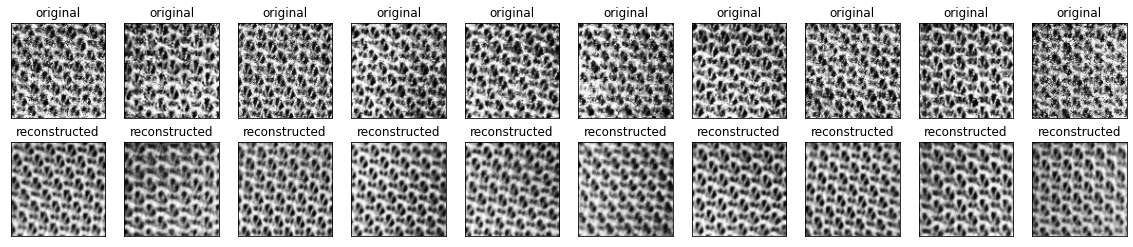

In [9]:
xs, ys = next(train_gen)
encoded_imgs = renet.encoder(xs).numpy()
decoded_imgs = renet.decoder(encoded_imgs).numpy()
show_imgs(xs, decoded_imgs)

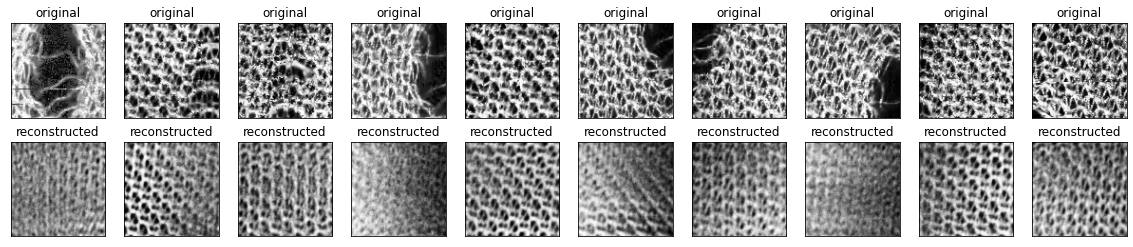

In [10]:
xs, ys = next(an_gen)
encoded_imgs = renet.encoder(xs).numpy()
decoded_imgs = renet.decoder(encoded_imgs).numpy()
show_imgs(xs, decoded_imgs)

In [11]:
def cal_mse_losses(model, gen, batch_size):
    losses = []
    num = gen.samples
    for i, (xs, ys) in enumerate(gen):
        if i > num//batch_size:
            break
        res = model.predict(xs)
        for r, x in zip(res, xs):
            losses.append((np.square(r - x)).mean())
    return losses

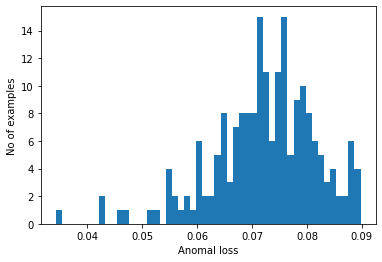

In [12]:
anomal_losses = cal_mse_losses(renet, an_gen, batch_size)

plt.hist(anomal_losses, bins=50)
plt.xlabel("Anomal loss")
plt.ylabel("No of examples")
plt.show()

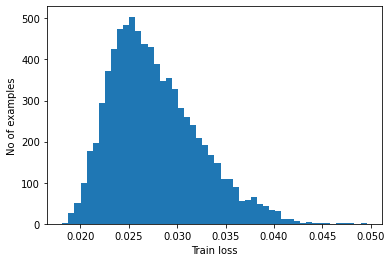

In [13]:
train_loss = cal_mse_losses(renet, train_gen, batch_size)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

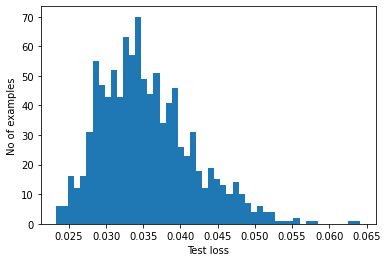

In [14]:
test_loss = cal_mse_losses(renet, test_gen, batch_size)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

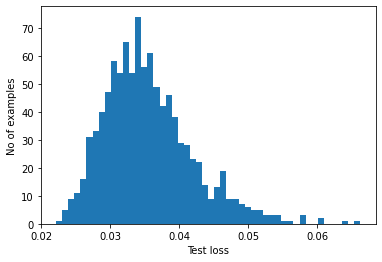

In [15]:
val_loss = cal_mse_losses(renet, val_gen, batch_size)

plt.hist(val_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


In [26]:
def cal_acc(losses, threshold, is_nomal):
    losses = np.array(losses)
    if is_nomal:
        return np.count_nonzero(losses <= threshold) / len(losses)
    else:
        return np.count_nonzero(losses >= threshold) / len(losses)

threshold = 0.0545
print(f'anomal data predict acc: {cal_acc(anomal_losses, threshold, is_nomal=False)}')
print(f'nomal train data predict acc: {cal_acc(train_loss, threshold, is_nomal=True)}')
print(f'nomal test data predict acc: {cal_acc(test_loss, threshold, is_nomal=True)}')
print(f'nomal val data predict acc: {cal_acc(val_loss, threshold, is_nomal=True)}')

anomal data predict acc: 0.9591836734693877
nomal train data predict acc: 1.0
nomal test data predict acc: 0.9930486593843099
nomal val data predict acc: 0.9910536779324056


In [20]:
def read_img(f):
    img = cv2.imread(f, 0)
    img = np.asarray(img)
    img = np.expand_dims(img,axis=-1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

anomal_img = read_img('./data1/anomal_data/anomal/4701.bmp')
nomal_img = read_img('./data1/nomal_data/nomal/0.bmp')

model = tf.keras.models.load_model('./model/renet')

re_nomal_img = model.predict(tf.stack([nomal_img]))
re_anomal_img = model.predict(tf.stack([anomal_img]))

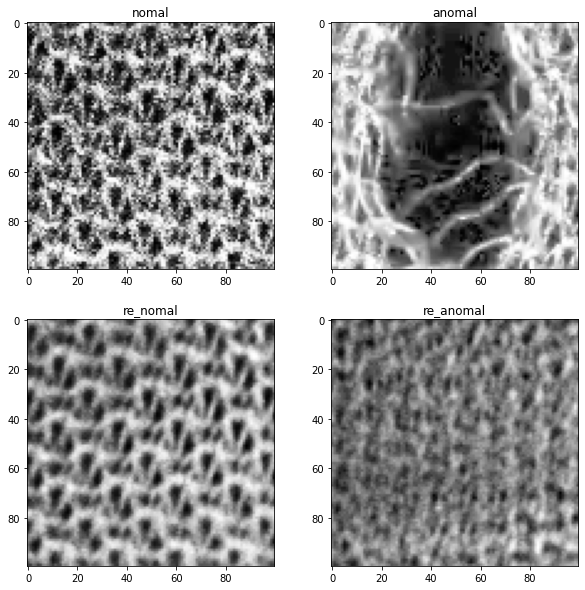

In [21]:
titles = ['nomal', 'anomal', 're_nomal', 're_anomal']
imgs = [nomal_img, anomal_img, re_nomal_img[0], re_anomal_img[0]]

plt.figure(figsize=(10, 10))
for i,(title, img) in enumerate(zip(titles, imgs)):
    plt.subplot(2,2, i +1)
    plt.imshow(img, cmap='gray')
    plt.title(title)

In [22]:
def predict(r, x):
    if np.square(r - x).mean() >= threshold:
        return 'anomal'
    else:
        return 'nomal'

print(f'nomal img, predict is : {predict(nomal_img, re_nomal_img)}')
print(f'anomal img, predict is : {predict(anomal_img, re_anomal_img)}')

nomal img, predict is : nomal
anomal img, predict is : anomal
